In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K 
from tensorflow.keras.utils import plot_model
import cv2
import glob
import random


### Helper Functions

In [2]:
# Function to create and save augmented images
# It returns dataframe with similar image pairs
def augmented_image_generation(folder_path,save_path):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            rotation_range=40,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            vertical_flip = True,
                                            brightness_range = [0.01,0.4],
                                            fill_mode='nearest')
    df = pd.DataFrame(glob.glob(folder_path+'/*.jpg'))

    if os.path.exists(save_path):
      shutil.rmtree(save_path)
      os.mkdir(save_path)
    else:
      os.mkdir(save_path)


    for x, val in zip(datagen.flow_from_dataframe(dataframe=df,x_col=0,class_mode= None,save_prefix='aug', save_format='jpg', save_to_dir=save_path,batch_size=1),range(df.shape[0]-1)):
        pass

    df_aug = pd.DataFrame(glob.glob(save_path+'/*.jpg'))
    df_aug['index'] = [int(df_aug[0][i].split('_')[1]) for i in range(df_aug.shape[0])]
    df = df.reset_index()
    df = df.merge(df_aug,on='index',how='left')
    df['score'] = np.zeros(df.shape[0])

    return df
                                                        
# Function to create dataframe of different image pairs
def different_pairs(real_path):
    file_1 = glob.glob(real_path+'/*.jpg')
    file_2 = file_1.copy()
    random.shuffle(file_2)
    diff_images =[]
    zipped = zip(file_1, file_2)
    diff_images.append(list(zipped))

    df = pd.DataFrame(diff_images[0])
    df['score'] = np.ones(len(diff_images[0]))

    return df

    

def data_generator(dataframe):
  file_1 = list(dataframe.file_1)
  file_2 = list(dataframe.file_2)
  score = list(dataframe.score)

  for i in range(len(file_1)):
    try:
      x_a = cv2.imread(file_1[i])
      x_a = (cv2.resize(x_a,(224,224)))/255
      x_a = x_a.reshape(1, 224, 224, 3)
      
      x_b = cv2.imread(file_2[i])
      x_b = (cv2.resize(x_b,(224,224)))/255
      x_b = x_b.reshape(1, 224, 224, 3)
      
      y = np.expand_dims(np.array(score[i]),axis=0)
      yield (x_a, x_b), y
    except:
      continue

### Data Generation

In [3]:
sim_df = augmented_image_generation(folder_path='./data/sample_data/',save_path='./data/augmented/')
sim_df.columns = ['index','file_1','file_2','score']

Found 1553 validated image filenames.


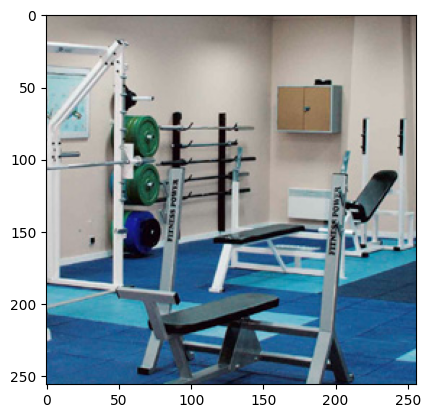

In [4]:
plt.imshow(cv2.imread(sim_df['file_1'][100]))

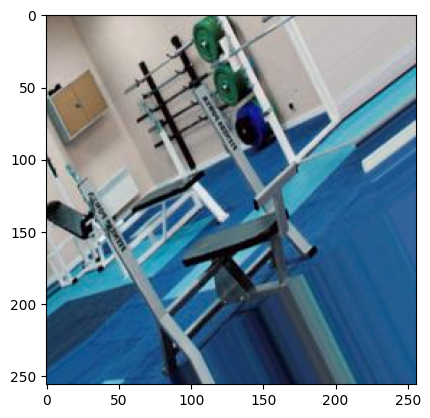

In [5]:
plt.imshow(cv2.imread(sim_df['file_2'][100]))

In [6]:
diff_df = different_pairs(real_path='./data/sample_data/')
diff_df.columns = ['file_1','file_2','score']

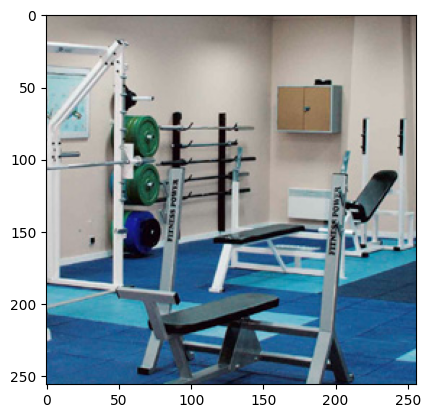

In [7]:
plt.imshow(cv2.imread(diff_df['file_1'][100]))

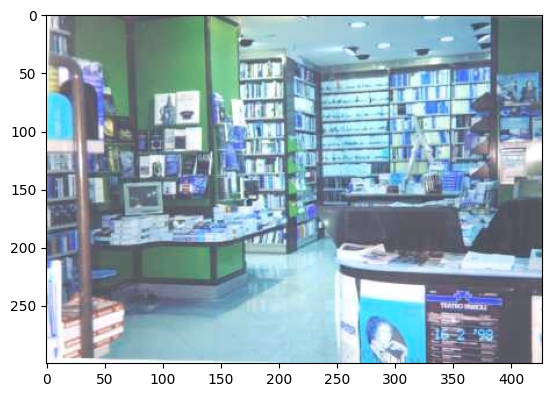

In [8]:
plt.imshow(cv2.imread(diff_df['file_2'][100]))

In [9]:
final_df = (pd.concat([sim_df,diff_df],axis=0)).sample(frac=1)
final_df = final_df.convert_dtypes()
final_df['score'] =final_df['score'].astype('float32')


In [10]:
train_df = final_df[:int(0.8*final_df.shape[0])]
val_df = final_df[int(0.8*final_df.shape[0]):]

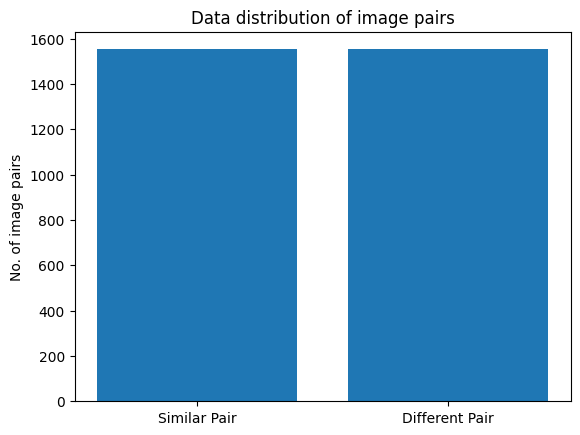

In [11]:
plt.bar(['Similar Pair','Different Pair'],[final_df[final_df['score']==0].shape[0], final_df[final_df['score']==1].shape[0]])
plt.ylabel("No. of image pairs")
plt.title("Data distribution of image pairs")
plt.show()

### Model

In [12]:
class ResBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ResBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

In [13]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 3, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))
        self.dropout = tf.keras.layers.Dropout(0.2)

        # Use the Identity blocks that you just defined
        self.block1 = ResBlock(64, 3)
        self.block2 = ResBlock(64, 3)
        self.block3 = ResBlock(64, 3)
        self.block4 = ResBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.final_vector = tf.keras.layers.Dense(16,activation='relu')

        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.block1(x)
        x = self.dropout(x)
        x = self.block2(x)
        x = self.dropout(x)
        x = self.block3(x)
        x = self.dropout(x)
        x = self.block4(x)
        x = self.dropout(x)

        x = self.global_pool(x)

        return self.final_vector(x)

In [14]:
base_model = ResNet()

In [15]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
input_a = tf.keras.layers.Input(shape=(224,224,3), name="left_input")
vect_output_a = base_model(input_a)

input_b = tf.keras.layers.Input(shape=(224,224,3), name="right_input")
vect_output_b = base_model(input_b)

output = tf.keras.layers.Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

final_model = tf.keras.models.Model([input_a, input_b], output)


In [17]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)

In [18]:
final_model.compile(loss= contrastive_loss, optimizer=tf.keras.optimizers.Adam())
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 res_net (ResNet)               (None, 16)           300560      ['left_input[0][0]',             
                                                                  'right_input[0][0]']        

In [19]:
# Callback to save only the best model by monitoring val_loss
earlyStopping = tf.keras.callbacks.ModelCheckpoint(filepath="siamese_model.h5",save_weights_only=False,monitor="val_loss", mode="min", save_best_only=True)

### Training

In [20]:
history = {}
for epochs in range(10):
    history[epochs] = final_model.fit(data_generator(train_df),validation_data=data_generator(val_df),callbacks=[earlyStopping])

2022-11-16 20:35:08.348130: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2481/2481 [==============================] - 253s 102ms/step - loss: 0.0421 - val_loss: 0.5232


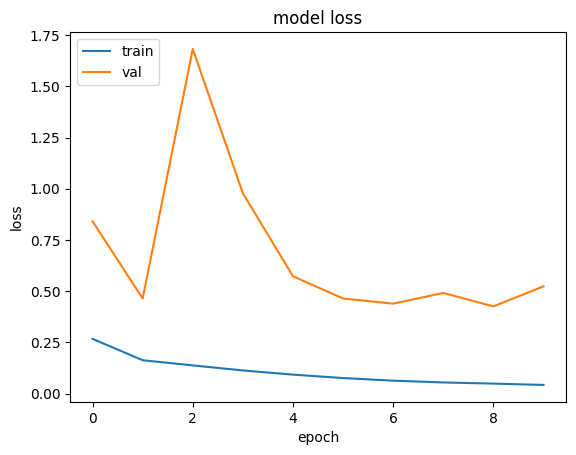

In [21]:

plt.plot([history[i].history['loss'] for i in history.keys()])
plt.plot([history[i].history['val_loss'] for i in history.keys()])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()